In [82]:
import numpy as np


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from scipy.spatial import distance
from scipy.linalg import norm
from scipy.spatial.distance import euclidean
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()
import matplotlib.pyplot as plt
import pandas as pd

from qiskit.quantum_info.analysis.distance import hellinger_distance

In [83]:
# error probabilties, I took the following value randomly
#wondering should I take them randomly
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
measure_error = 0.2 # P(measure error)
gate_error = 0.05 # P(two qubit error)

# calling error functions using from IBM library
re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
gate_err2 = gate_err1.tensor(gate_err1)

# errors on a noisy model
bitflip_err = NoiseModel()
bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")

print(bitflip_err)



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['reset', 'u2', 'measure', 'u3', 'cx', 'u1']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [84]:
distance_dataframe = pd.DataFrame(columns=["State Name", "Error Introduced", "TVD Distribution", 
                                           "Jensen-Shannon Distance", "Hellinger Distance"])

distance_dataframe

,State Name,Error Introduced,TVD Distribution,Jensen-Shannon Distance,Hellinger Distance


In [85]:
def generate_plot(ideal_counts, calculated_counts, error_name, circ_name):
    # Match both dictionaries key 
    for key in calculated_counts:
        if key not in ideal_counts:
            ideal_counts[key] = 0
    
    for key in ideal_counts:
        if key not in calculated_counts:
            calculated_counts[key] = 0
            
    ideal_counts = dict(sorted(ideal_counts.items()))
    calculated_counts = dict(sorted(calculated_counts.items()))
    
    #Probability Distribution
    s_ideal = sum(ideal_counts.values())
    for key, value in ideal_counts.items():
        percentage = value / s_ideal
        ideal_counts[key] = percentage
        
    s_calculated = sum(calculated_counts.values())
    for key, value in calculated_counts.items():
        percentage = value / s_calculated
        calculated_counts[key] = percentage
    
    fname = f'./Images/Bar_charts/{error_name}_{circ_name}.pdf'
        
    X = np.arange(len(calculated_counts))
    f, ax = plt.subplots(figsize=(12,8))
    ax.bar(X-0.2, calculated_counts.values(), width=0.4, align='center', edgecolor='black')
    ax.bar(X+0.2, ideal_counts.values(), width=0.4, align='center', edgecolor='black')
    ax.legend(('Calculated Probability','Ideal Probability'), fontsize=15)
    plt.xticks(X, calculated_counts.keys(), fontsize=13)
    plt.xticks(X, ideal_counts.keys(), fontsize=13)
    plt.yticks(fontsize=13)
    plt.xticks(rotation=90)
    plt.xlabel("States", fontsize=16)
    plt.ylabel("Probability", fontsize=16)
    plt.savefig(fname)
    plt.show()

In [86]:
def bit_error(circ, qubits, circ_name):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error


    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    bitflip_err = NoiseModel()
    bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
    bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
    bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()

    legend = ['ideal', 'bit_flip']

    # Plot noisy output
    
    generate_plot(ideal_counts, counts_bit_flip, 'bit_error', circ_name)
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_bit_flip.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_bit_flip:
            counts_bit_flip[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print(' TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_bit_flip[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_bit_flip[key]/N2)
        print(tvd)
    
    
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_bit_flip.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
    hell4 = hellinger_distance(ideal_counts, counts_bit_flip)
    print(hell4)
    
    distance_dataframe.loc[len(distance_dataframe.index)] = [circ_name, "Bit Error", tvd, jsd, hell4]
    
    return 

def ideal(circ):
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()

    
    return ideal_counts, ideal_counts, counts_bit_flip

In [87]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()

┌───┐          ┌─┐      
q362_0: ┤ H ├──■───────┤M├──────
        └───┘┌─┴─┐     └╥┘┌─┐   
q362_1: ─────┤ X ├──■───╫─┤M├───
             └───┘┌─┴─┐ ║ └╥┘┌─┐
q362_2: ──────────┤ X ├─╫──╫─┤M├
                  └───┘ ║  ║ └╥┘
 c10: 3/════════════════╩══╩══╩═
                        0  1  2

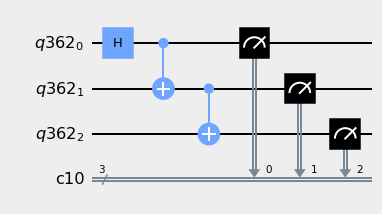

In [88]:
circuit_drawer(ghz_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/ghz_circ.pdf')

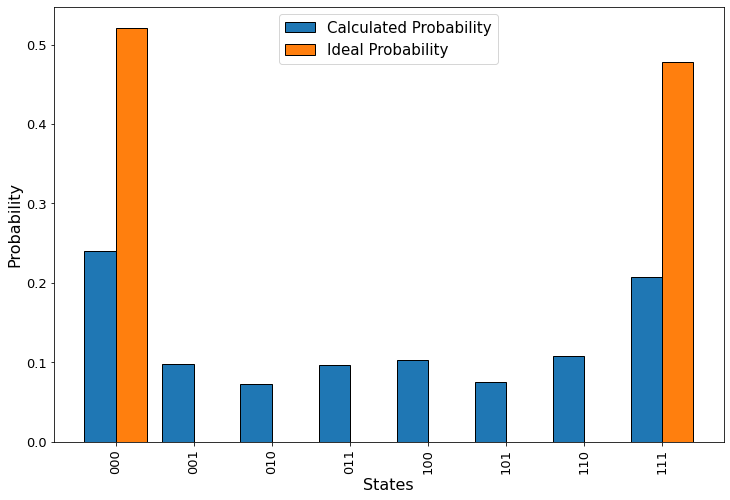

 TVD Distribution
111
490 212
0.1357421875
000
534 246
0.2763671875
001
0 100
0.3251953125
010
0 75
0.36181640625
101
0 77
0.3994140625
011
0 99
0.44775390625
110
0 110
0.50146484375
100
0 105
0.552734375
Jensen-Shannon Distance
0.6716258443327696
Hellinger Distance
24.546193245110704
24.546193245110704
24.546193245110704
0.5755890973609971


In [89]:
bit_error(ghz_circ, len(q_ghz), 'GHZ')

In [90]:
def t1_t2(qubits, circ, circ_name):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    # Run the noisy simulation
    sim_thermal = AerSimulator(noise_model=noise_thermal)

    # Transpile circuit for noisy basis gates
    tthermal = transpile(circ, sim_thermal)

    # Run and get counts
    result_thermal = sim_thermal.run(tthermal).result()
    counts_thermal = result_thermal.get_counts()
    legend_t = ['ideal', 'thermal']

    # Plot noisy output
    generate_plot(ideal_counts, counts_thermal, 't1_t2', circ_name)
    
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_thermal.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_thermal:
            counts_thermal[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print('TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_thermal[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_thermal[key]/N2)
        print(tvd)
        
        
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_thermal.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
    hell4 = hellinger_distance(ideal_counts, counts_thermal)
    print(hell4)
    
    distance_dataframe.loc[len(distance_dataframe.index)] = [circ_name, "Thermal Error", tvd, jsd, hell4]
    
    return 

    

In [91]:
def depolar(qubits, circ, circ_name):

    p_gate = 0.1
    error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_depolar = NoiseModel()
    noise_depolar.add_all_qubit_quantum_error(error_meas, "measure", qubits)
    
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()

    # Run the noisy simulation
    sim_depolar = AerSimulator(noise_model=noise_depolar)

    # Transpile circuit for noisy basis gates
    depolar = transpile(circ, sim_depolar)

    # Run and get counts
    result_depolar = sim_depolar.run(depolar).result()
    counts_depolar = result_depolar.get_counts()
    legend_t = ['ideal', 'depolar']

    # Plot noisy output
    generate_plot(ideal_counts, counts_depolar, 'depolar', circ_name)
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_depolar.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_depolar:
            counts_depolar[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print('TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_depolar[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_depolar[key]/N2)
        print(tvd)
    
    
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_depolar.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
    hell4 = hellinger_distance(ideal_counts, counts_depolar)
    print(hell4)
    
    distance_dataframe.loc[len(distance_dataframe.index)] = [circ_name, "Depolarizing Error", tvd, jsd, hell4]
                              
    
    return tvd, jsd, hell1, hell2, hell3

In [92]:
def tvd_calculator(dist_1, dist_2, num_qubits):
    """This function accepts two counts distributions as dictionaries
    and computes the total variation distribution (TVD) between them

    Args:
        dist1 & dist2: counts dictionary from IBM backend/simulator.
               example, {'00': 4000, '01': 4192}
        num_qubits: number of measured qubits in the qunatum circuits.

    Returns:
        tvd: Total variation distribution between two distributions
    """
    num_binary_states = 2**num_qubits

    # get the total counts for two dictionaries
    N1 = sum(dist_1.values())
    N2 = sum(dist_2.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**num_qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(num_qubits)

        if binary_state not in dist_1:
            dist_1[binary_state] = 0
        
        if binary_state not in dist_2:
            dist_2[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    for key in dist_1:
        print(dist_1[key], dist_2[key])
        tvd = tvd + 0.5 * abs(dist_1[key]/N1 - dist_2[key]/N2)

    return tvd


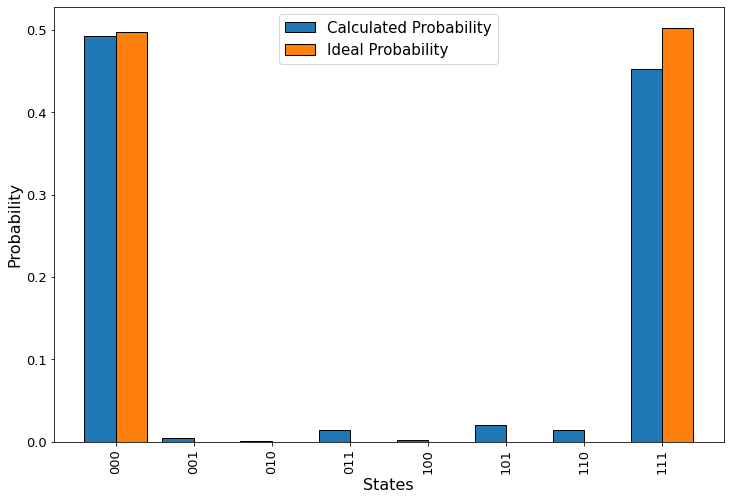

TVD Distribution
111
515 463
0.025390625
000
509 504
0.02783203125
010
0 1
0.0283203125
100
0 2
0.029296875
110
0 15
0.03662109375
011
0 14
0.04345703125
101
0 21
0.0537109375
001
0 4
0.0556640625
Jensen-Shannon Distance
0.8265721770556366
Hellinger Distance
31.13519353235325
31.13519353235325
31.13519353235325
0.16885952921066133


In [93]:
t1_t2(len(q_ghz), ghz_circ, 'GHZ')

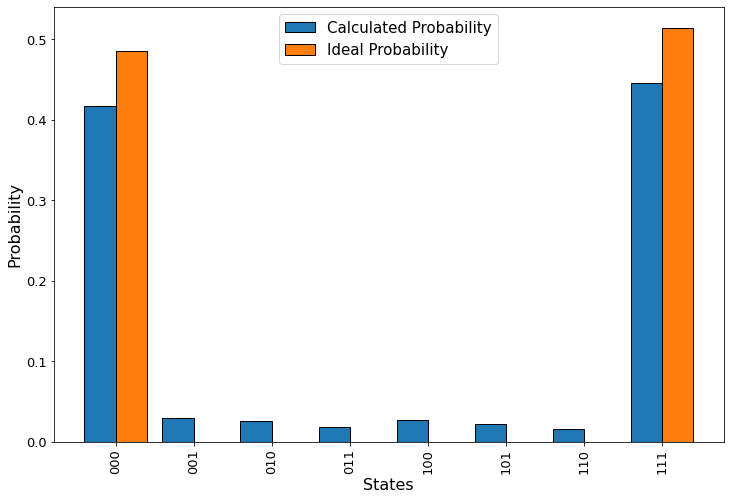

TVD Distribution
000
497 427
0.0341796875
111
527 456
0.06884765625
001
0 30
0.08349609375
101
0 23
0.0947265625
010
0 26
0.107421875
110
0 16
0.115234375
100
0 27
0.12841796875
011
0 19
0.1376953125
Jensen-Shannon Distance
0.7683090402451882
Hellinger Distance
28.138906800939438
28.138906800939438
28.138906800939438
0.26720373937288405


(0.1376953125,
 0.7683090402451882,
 28.138906800939438,
 28.138906800939438,
 28.138906800939438)

In [94]:
depolar(len(q_ghz), ghz_circ, 'GHZ')

In [95]:
#Mermin_Bell gate
from math import pi
mer_bell = QuantumRegister(3)
mer_bell_c =  ClassicalRegister(3)
mer_bell_circ = QuantumCircuit(mer_bell, mer_bell_c)
mer_bell_circ.rx(-pi/2, mer_bell[0])
mer_bell_circ.cx(mer_bell[0], mer_bell[1])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cx(mer_bell[0], mer_bell[2])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.cx(mer_bell[2], mer_bell[0])
mer_bell_circ.cx(mer_bell[1], mer_bell[0])
mer_bell_circ.s(mer_bell[2])
mer_bell_circ.s(mer_bell[0])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cz(mer_bell[0], mer_bell[1])
mer_bell_circ.h(mer_bell[0])
mer_bell_circ.s(mer_bell[1])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.measure(mer_bell[0:3], mer_bell_c[0:3])
display(mer_bell_circ.draw())
                           

┌──────────┐                         ┌───┐┌───┐┌───┐   ┌───┐     ┌─┐   
q388_0: ┤ Rx(-π/2) ├──■──────────────■───────┤ X ├┤ X ├┤ S ├─■─┤ H ├─────┤M├───
        └──────────┘┌─┴─┐     ┌───┐  │       └─┬─┘└─┬─┘└───┘ │ ├───┤┌───┐└╥┘┌─┐
q388_1: ────────────┤ X ├──■──┤ H ├──┼────■────┼────■────────■─┤ S ├┤ H ├─╫─┤M├
                    └───┘┌─┴─┐├───┤┌─┴─┐┌─┴─┐  │  ┌───┐┌───┐┌─┐└───┘└───┘ ║ └╥┘
q388_2: ─────────────────┤ X ├┤ H ├┤ X ├┤ X ├──■──┤ S ├┤ H ├┤M├───────────╫──╫─
                         └───┘└───┘└───┘└───┘     └───┘└───┘└╥┘           ║  ║ 
 c11: 3/═════════════════════════════════════════════════════╩════════════╩══╩═
                                                             2            0  1

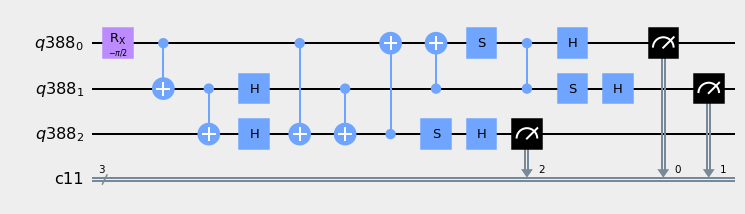

In [96]:
circuit_drawer(mer_bell_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/mer_bell_circ.pdf')

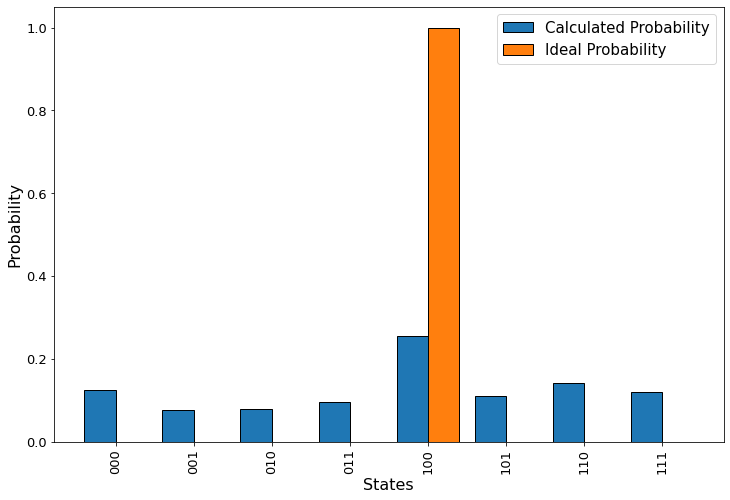

 TVD Distribution
100
1024 261
0.37255859375
001
0 78
0.41064453125
010
0 80
0.44970703125
111
0 122
0.50927734375
000
0 128
0.57177734375
011
0 99
0.6201171875
110
0 144
0.6904296875
101
0 112
0.7451171875
Jensen-Shannon Distance
0.7453750270348212
Hellinger Distance
27.22836117502316
27.22836117502316
27.22836117502316
0.7036624185865977


In [97]:
bit_error(mer_bell_circ, len(mer_bell), 'Mermin')

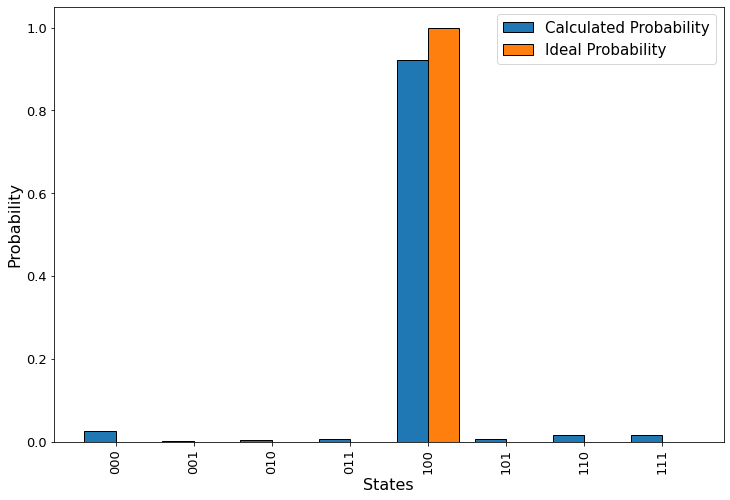

TVD Distribution
100
1024 944
0.0390625
001
0 2
0.0400390625
010
0 5
0.04248046875
111
0 17
0.05078125
011
0 6
0.0537109375
000
0 26
0.06640625
110
0 17
0.07470703125
101
0 7
0.078125
Jensen-Shannon Distance
0.828297984492456
Hellinger Distance
31.284903164370846
31.284903164370846
31.28490316437084
0.1996416327232974


In [98]:
t1_t2(len(mer_bell), mer_bell_circ, 'Mermin')

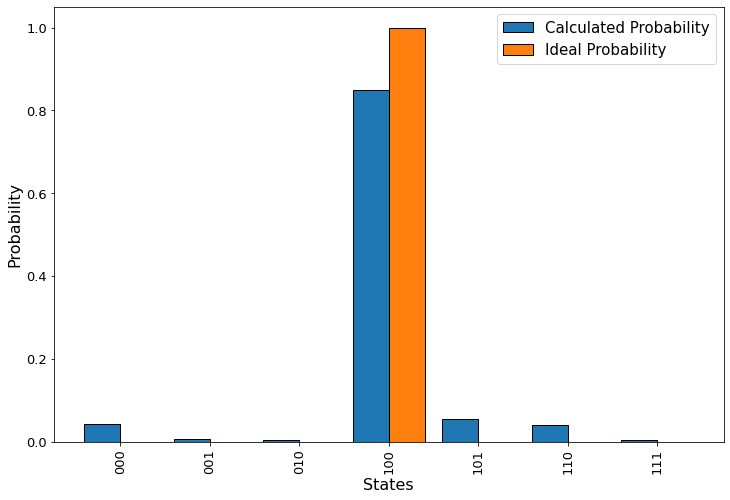

TVD Distribution
100
1024 869
0.07568359375
001
0 6
0.07861328125
101
0 55
0.10546875
111
0 5
0.10791015625
000
0 43
0.12890625
110
0 41
0.14892578125
010
0 5
0.1513671875
011
0 0
0.1513671875
Jensen-Shannon Distance
0.8216758337206348
Hellinger Distance
30.7508752433315
30.7508752433315
30.7508752433315
0.28069078037677025


(0.1513671875,
 0.8216758337206348,
 30.7508752433315,
 30.7508752433315,
 30.7508752433315)

In [99]:
depolar(len(mer_bell), mer_bell_circ, 'Mermin')

In [100]:
#phase code
phase_q = QuantumRegister(5)
phase_c = ClassicalRegister(5)
phase_circ = QuantumCircuit(phase_q, phase_c)
phase_circ.h(phase_q[0])
phase_circ.initialize([1,0], 1)
phase_circ.x(phase_q[2])
phase_circ.initialize([1,0], 3)
phase_circ.h(phase_q[4])
phase_circ.h(phase_q[0:5])
phase_circ.cz(phase_q[0], phase_q[1])
phase_circ.h(phase_q[2])
phase_circ.h(phase_q[0])
phase_circ.cz(phase_q[1], phase_q[2])
phase_circ.h(phase_q[1])
phase_circ.cz(phase_q[2], phase_q[3])
phase_circ.h(phase_q[2])
phase_circ.cz(phase_q[3], phase_q[4])
phase_circ.h(phase_q[3])
phase_circ.h(phase_q[4])
phase_circ.barrier()
phase_circ.measure(phase_q[0:4], phase_c[0:4])
display(phase_circ.draw())


┌───┐       ┌───┐     ┌───┐                ░ ┌─┐         
q439_0: ───────┤ H ├───────┤ H ├──■──┤ H ├────────────────░─┤M├─────────
        ┌──────┴───┴──────┐├───┤  │  └───┘┌───┐           ░ └╥┘┌─┐      
q439_1: ┤ Initialize(1,0) ├┤ H ├──■────■──┤ H ├───────────░──╫─┤M├──────
        └──────┬───┬──────┘├───┤┌───┐  │  └───┘┌───┐      ░  ║ └╥┘┌─┐   
q439_2: ───────┤ X ├───────┤ H ├┤ H ├──■────■──┤ H ├──────░──╫──╫─┤M├───
        ┌──────┴───┴──────┐├───┤└───┘       │  └───┘┌───┐ ░  ║  ║ └╥┘┌─┐
q439_3: ┤ Initialize(1,0) ├┤ H ├────────────■────■──┤ H ├─░──╫──╫──╫─┤M├
        └──────┬───┬──────┘├───┤                 │  ├───┤ ░  ║  ║  ║ └╥┘
q439_4: ───────┤ H ├───────┤ H ├─────────────────■──┤ H ├─░──╫──╫──╫──╫─
               └───┘       └───┘                    └───┘ ░  ║  ║  ║  ║ 
 c12: 5/═════════════════════════════════════════════════════╩══╩══╩══╩═
                                                             0  1  2  3

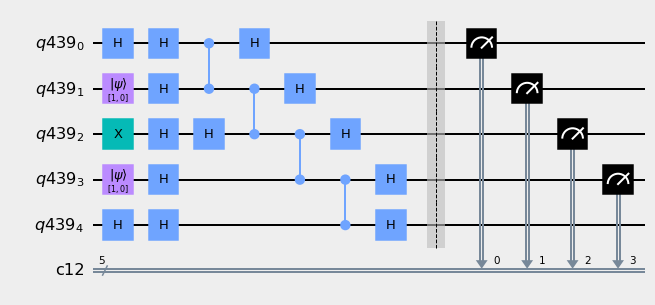

In [101]:
circuit_drawer(phase_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/phase_circ.pdf')

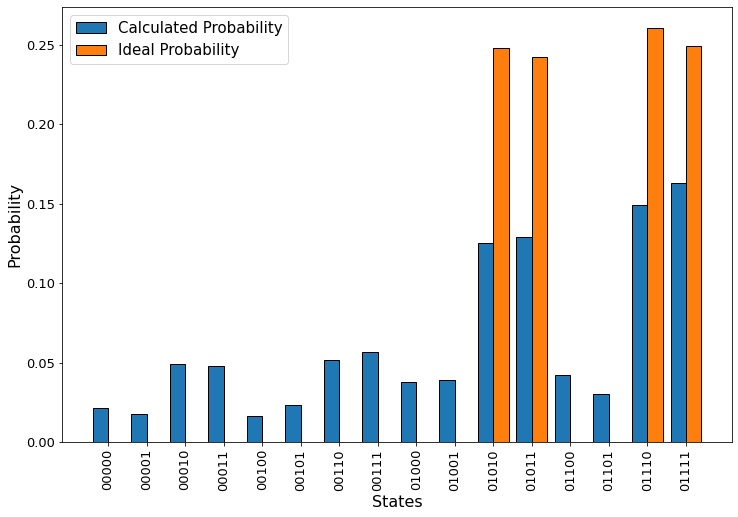

 TVD Distribution
01010
254 128
0.0615234375
01111
255 167
0.1044921875
01011
248 132
0.1611328125
01110
267 153
0.216796875
01101
0 31
0.23193359375
01000
0 39
0.2509765625
00001
0 18
0.259765625
00101
0 24
0.271484375
01100
0 43
0.29248046875
00011
0 49
0.31640625
00000
0 22
0.3271484375
00111
0 58
0.35546875
00010
0 50
0.3798828125
00100
0 17
0.38818359375
00110
0 53
0.4140625
01001
0 40
0.43359375
10000
0 0
0.43359375
10001
0 0
0.43359375
10010
0 0
0.43359375
10011
0 0
0.43359375
10100
0 0
0.43359375
10101
0 0
0.43359375
10110
0 0
0.43359375
10111
0 0
0.43359375
11000
0 0
0.43359375
11001
0 0
0.43359375
11010
0 0
0.43359375
11011
0 0
0.43359375
11100
0 0
0.43359375
11101
0 0
0.43359375
11110
0 0
0.43359375
11111
0 0
0.43359375
Jensen-Shannon Distance
0.7186650047293162
Hellinger Distance
26.24264964182919
26.24264964182919
26.24264964182919
0.49831806415860025


In [102]:
bit_error(phase_circ, len(phase_q), 'Phase')

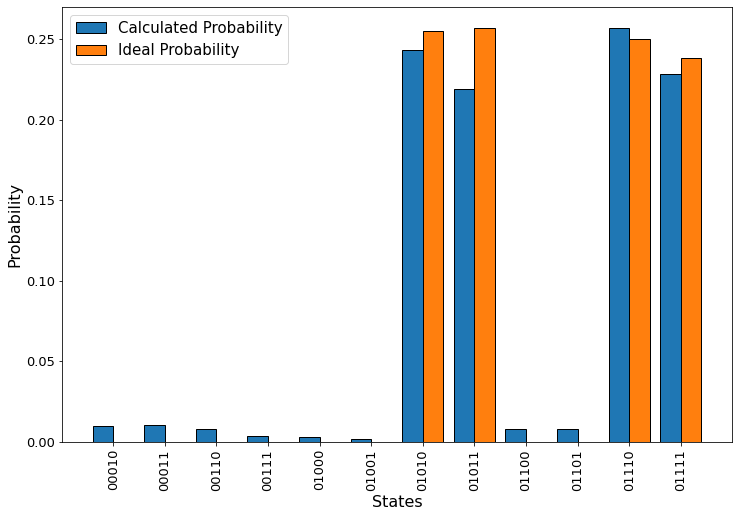

TVD Distribution
01111
244 234
0.0048828125
01110
256 263
0.00830078125
01010
261 249
0.01416015625
01011
263 224
0.033203125
01001
0 2
0.0341796875
00010
0 10
0.0390625
01000
0 3
0.04052734375
01100
0 8
0.04443359375
01101
0 8
0.04833984375
00011
0 11
0.0537109375
00111
0 4
0.0556640625
00110
0 8
0.0595703125
00000
0 0
0.0595703125
00001
0 0
0.0595703125
00100
0 0
0.0595703125
00101
0 0
0.0595703125
10000
0 0
0.0595703125
10001
0 0
0.0595703125
10010
0 0
0.0595703125
10011
0 0
0.0595703125
10100
0 0
0.0595703125
10101
0 0
0.0595703125
10110
0 0
0.0595703125
10111
0 0
0.0595703125
11000
0 0
0.0595703125
11001
0 0
0.0595703125
11010
0 0
0.0595703125
11011
0 0
0.0595703125
11100
0 0
0.0595703125
11101
0 0
0.0595703125
11110
0 0
0.0595703125
11111
0 0
0.0595703125
Jensen-Shannon Distance
0.800650800394578
Hellinger Distance
29.621973575015996
29.621973575015996
29.621973575015996
0.16514838806689577


In [103]:
t1_t2(len(phase_q), phase_circ, 'Phase')

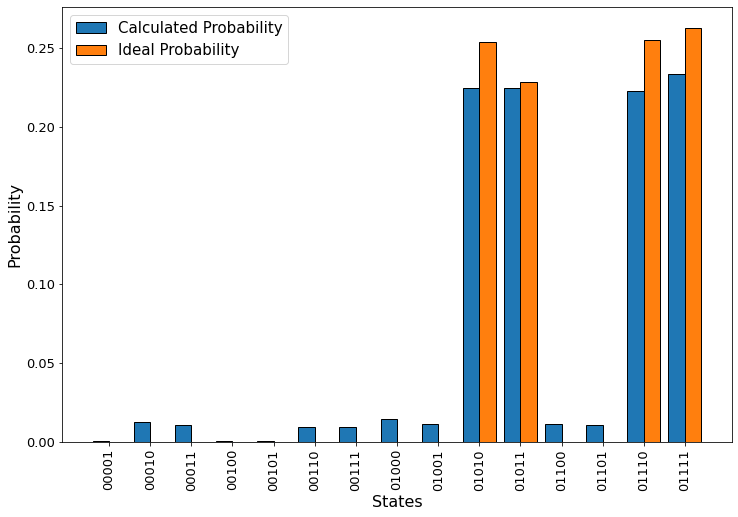

TVD Distribution
01111
269 239
0.0146484375
01110
261 228
0.03076171875
01011
234 230
0.03271484375
01010
260 230
0.04736328125
00101
0 1
0.0478515625
01100
0 12
0.0537109375
01000
0 15
0.06103515625
01001
0 12
0.06689453125
00111
0 10
0.07177734375
00011
0 11
0.0771484375
00001
0 1
0.07763671875
01101
0 11
0.0830078125
00100
0 1
0.08349609375
00110
0 10
0.08837890625
00010
0 13
0.0947265625
00000
0 0
0.0947265625
10000
0 0
0.0947265625
10001
0 0
0.0947265625
10010
0 0
0.0947265625
10011
0 0
0.0947265625
10100
0 0
0.0947265625
10101
0 0
0.0947265625
10110
0 0
0.0947265625
10111
0 0
0.0947265625
11000
0 0
0.0947265625
11001
0 0
0.0947265625
11010
0 0
0.0947265625
11011
0 0
0.0947265625
11100
0 0
0.0947265625
11101
0 0
0.0947265625
11110
0 0
0.0947265625
11111
0 0
0.0947265625
Jensen-Shannon Distance
0.78370857789413
Hellinger Distance
28.922867995154633
28.922867995154633
28.922867995154633
0.22090217994853484


(0.0947265625,
 0.78370857789413,
 28.922867995154633,
 28.922867995154633,
 28.922867995154633)

In [104]:
depolar(len(phase_q), phase_circ, 'Phase')

In [105]:
#bit code
bit_q  = QuantumRegister(5)
bit_c = ClassicalRegister(5)
bit_circ = QuantumCircuit(bit_q,bit_c)
bit_circ.barrier()
bit_circ.initialize([1,0], 1)
bit_circ.x(bit_q[2])
bit_circ.initialize([1,0], 3)
bit_circ.barrier()

bit_circ.cx(bit_q[0], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[3])
bit_circ.cx(bit_q[4], bit_q[3])
bit_circ.barrier()
bit_circ.measure(bit_q[0:5],bit_c[0:5])
display(bit_circ.draw())


░                     ░                      ░ ┌─┐            
q498_0: ─░─────────────────────░───■──────────────────░─┤M├────────────
         ░ ┌─────────────────┐ ░ ┌─┴─┐┌───┐           ░ └╥┘┌─┐         
q498_1: ─░─┤ Initialize(1,0) ├─░─┤ X ├┤ X ├───────────░──╫─┤M├─────────
         ░ └──────┬───┬──────┘ ░ └───┘└─┬─┘           ░  ║ └╥┘┌─┐      
q498_2: ─░────────┤ X ├────────░────────■────■────────░──╫──╫─┤M├──────
         ░ ┌──────┴───┴──────┐ ░           ┌─┴─┐┌───┐ ░  ║  ║ └╥┘┌─┐   
q498_3: ─░─┤ Initialize(1,0) ├─░───────────┤ X ├┤ X ├─░──╫──╫──╫─┤M├───
         ░ └─────────────────┘ ░           └───┘└─┬─┘ ░  ║  ║  ║ └╥┘┌─┐
q498_4: ─░─────────────────────░──────────────────■───░──╫──╫──╫──╫─┤M├
         ░                     ░                      ░  ║  ║  ║  ║ └╥┘
 c13: 5/═════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                         0  1  2  3  4

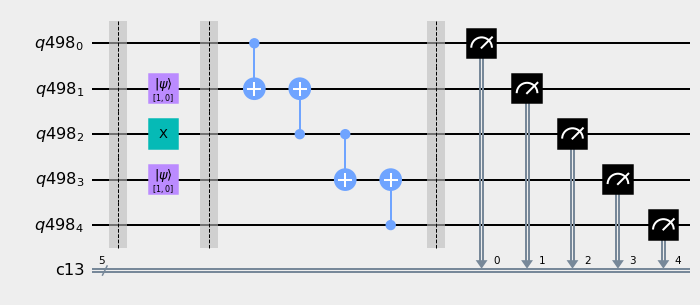

In [106]:
circuit_drawer(bit_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/bit_circ.pdf')

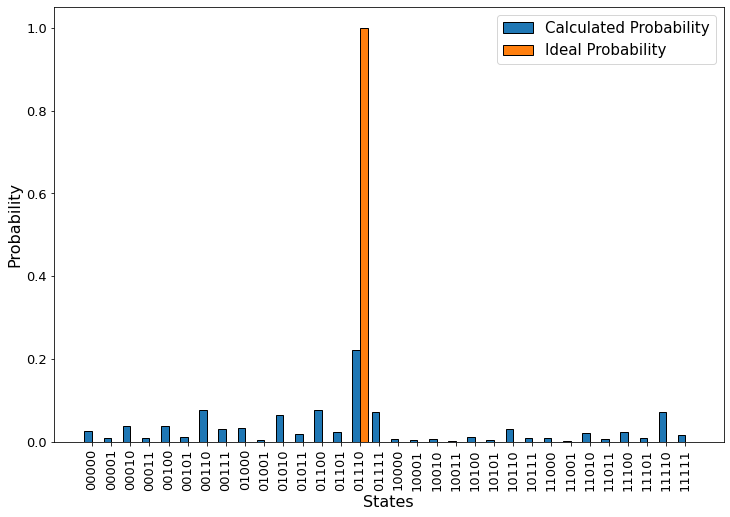

 TVD Distribution
01110
1024 227
0.38916015625
10011
0 3
0.390625
11011
0 7
0.39404296875
10101
0 4
0.39599609375
10000
0 7
0.3994140625
11010
0 22
0.41015625
00001
0 9
0.41455078125
01101
0 24
0.42626953125
00111
0 33
0.4423828125
01100
0 80
0.4814453125
01001
0 4
0.4833984375
00101
0 11
0.48876953125
00110
0 79
0.52734375
00011
0 10
0.5322265625
00100
0 39
0.55126953125
01011
0 19
0.560546875
00000
0 28
0.57421875
10001
0 4
0.576171875
01010
0 67
0.60888671875
01111
0 74
0.64501953125
01000
0 34
0.66162109375
00010
0 40
0.68115234375
11100
0 24
0.69287109375
11110
0 75
0.7294921875
11101
0 9
0.73388671875
10100
0 11
0.7392578125
10010
0 8
0.7431640625
10110
0 33
0.75927734375
11111
0 18
0.76806640625
10111
0 10
0.77294921875
11000
0 9
0.77734375
11001
0 2
0.7783203125
Jensen-Shannon Distance
0.8265203961954842
Hellinger Distance
31.12192754566779
31.12192754566779
31.12192754566779
0.7274415961668469


In [107]:
bit_error(bit_circ, len(bit_q), 'Bit')

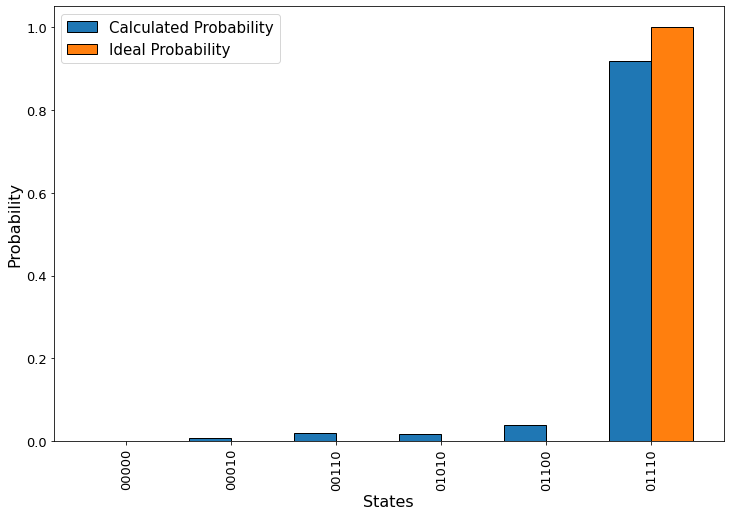

TVD Distribution
01110
1024 939
0.04150390625
01100
0 39
0.060546875
00010
0 7
0.06396484375
00000
0 1
0.064453125
00110
0 21
0.07470703125
01010
0 17
0.0830078125
00001
0 0
0.0830078125
00011
0 0
0.0830078125
00100
0 0
0.0830078125
00101
0 0
0.0830078125
00111
0 0
0.0830078125
01000
0 0
0.0830078125
01001
0 0
0.0830078125
01011
0 0
0.0830078125
01101
0 0
0.0830078125
01111
0 0
0.0830078125
10000
0 0
0.0830078125
10001
0 0
0.0830078125
10010
0 0
0.0830078125
10011
0 0
0.0830078125
10100
0 0
0.0830078125
10101
0 0
0.0830078125
10110
0 0
0.0830078125
10111
0 0
0.0830078125
11000
0 0
0.0830078125
11001
0 0
0.0830078125
11010
0 0
0.0830078125
11011
0 0
0.0830078125
11100
0 0
0.0830078125
11101
0 0
0.0830078125
11110
0 0
0.0830078125
11111
0 0
0.0830078125
Jensen-Shannon Distance
0.7819944911260257
Hellinger Distance
28.708188101154192
28.708188101154192
28.708188101154192
0.2059196678858405


In [108]:
t1_t2(len(bit_q), bit_circ, 'Bit')

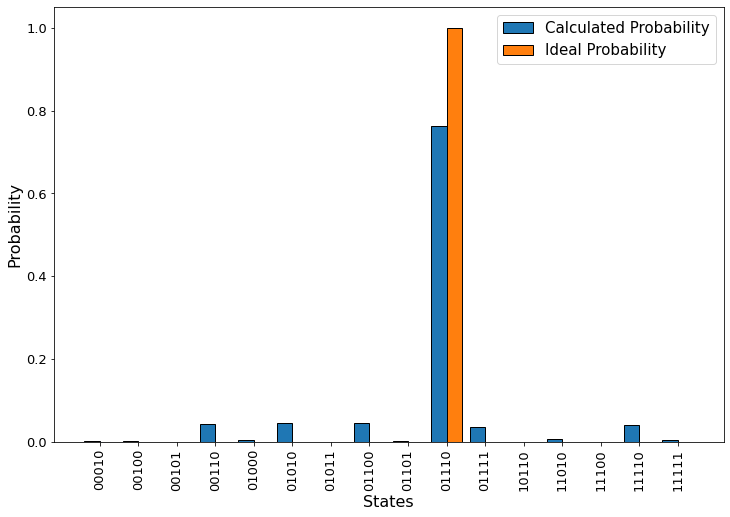

TVD Distribution
01110
1024 782
0.1181640625
01011
0 1
0.11865234375
01000
0 4
0.12060546875
01101
0 3
0.1220703125
11010
0 6
0.125
00100
0 3
0.12646484375
00110
0 44
0.14794921875
11111
0 4
0.14990234375
11100
0 1
0.150390625
10110
0 1
0.15087890625
00010
0 2
0.15185546875
11110
0 41
0.171875
00101
0 1
0.17236328125
01100
0 46
0.19482421875
01010
0 48
0.21826171875
01111
0 37
0.236328125
00000
0 0
0.236328125
00001
0 0
0.236328125
00011
0 0
0.236328125
00111
0 0
0.236328125
01001
0 0
0.236328125
10000
0 0
0.236328125
10001
0 0
0.236328125
10010
0 0
0.236328125
10011
0 0
0.236328125
10100
0 0
0.236328125
10101
0 0
0.236328125
10111
0 0
0.236328125
11000
0 0
0.236328125
11001
0 0
0.236328125
11011
0 0
0.236328125
11101
0 0
0.236328125
Jensen-Shannon Distance
0.8302253629294643
Hellinger Distance
31.49603149604724
31.49603149604724
31.49603149604724
0.35512924987693184


(0.236328125,
 0.8302253629294643,
 31.49603149604724,
 31.49603149604724,
 31.49603149604724)

In [109]:
depolar(len(bit_q), bit_circ, 'Bit')

In [110]:
swap_qaoa_q = QuantumRegister(4)
swap_qaoa_c = ClassicalRegister(4)
swap_qaoa_circ = QuantumCircuit(swap_qaoa_q, swap_qaoa_c)
swap_qaoa_circ.h(swap_qaoa_q[0:4])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/3, 0)
swap_qaoa_circ.rz(np.pi/3, 1)
swap_qaoa_circ.rz(np.pi/3, 2)
swap_qaoa_circ.rz(np.pi/3, 3)
swap_qaoa_circ.barrier()
swap_qaoa_circ.measure(swap_qaoa_q[0:4], swap_qaoa_c[0:4])
display(swap_qaoa_circ.draw())


┌───┐                ┌───┐                                          »
q546_0: ┤ H ├──■─────────────┤ X ├──■─────────────────────────■─────────────»
        ├───┤┌─┴─┐┌─────────┐└─┬─┘┌─┴─┐           ┌───┐     ┌─┴─┐┌─────────┐»
q546_1: ┤ H ├┤ X ├┤ Rz(π/2) ├──■──┤ X ├─────■─────┤ X ├──■──┤ X ├┤ Rz(π/2) ├»
        ├───┤└───┘├─────────┤┌───┐└───┘   ┌─┴─┐   └─┬─┘┌─┴─┐└───┘└─────────┘»
q546_2: ┤ H ├──■──┤ Rz(π/2) ├┤ X ├──■─────┤ X ├─────■──┤ X ├──■─────────────»
        ├───┤┌─┴─┐└─────────┘└─┬─┘┌─┴─┐┌──┴───┴──┐     └───┘┌─┴─┐┌─────────┐»
q546_3: ┤ H ├┤ X ├─────────────■──┤ X ├┤ Rz(π/2) ├──────────┤ X ├┤ Rz(π/2) ├»
        └───┘└───┘                └───┘└─────────┘          └───┘└─────────┘»
 c14: 4/════════════════════════════════════════════════════════════════════»
                                                                            »
«        ┌───┐     ┌─────────┐                                 ░ ┌─┐         
«q546_0: ┤ X ├──■──┤ Rz(π/3) ├─────────────────────────────────░─┤M├─────────
«        └─┬─┘┌─┴─┐└─────────┘           ┌───┐     ┌─────────┐ ░ └╥┘┌─┐      
«q546_1: ──■──┤ X ├─────■────────────────┤ X ├──■──┤ Rz(π/3) ├─░──╫─┤M├──────
«        ┌───┐└───┘   ┌─┴─┐   ┌─────────┐└─┬─┘┌─┴─┐├─────────┤ ░  ║ └╥┘┌─┐   
«q546_2: ┤ X ├──■─────┤ X ├───┤ Rz(π/2) ├──■──┤ X ├┤ Rz(π/3) ├─░──╫──╫─┤M├───
«        └─┬─┘┌─┴─┐┌──┴───┴──┐└─────────┘     └───┘└─────────┘ ░  ║  ║ └╥┘┌─┐
«q546_3: ──■──┤ X ├┤ Rz(π/3) ├─────────────────────────────────░──╫──╫──╫─┤M├
«             └───┘└─────────┘                                 ░  ║  ║  ║ └╥┘
« c14: 4/═════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                 0  1  2  3

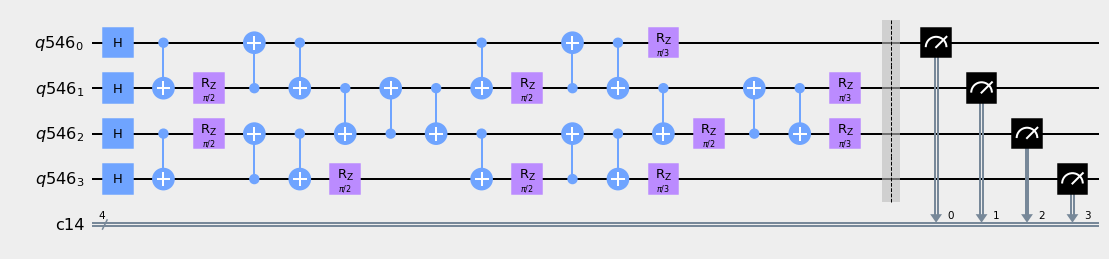

In [111]:
circuit_drawer(swap_qaoa_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/swap_qaoa_circ.pdf')

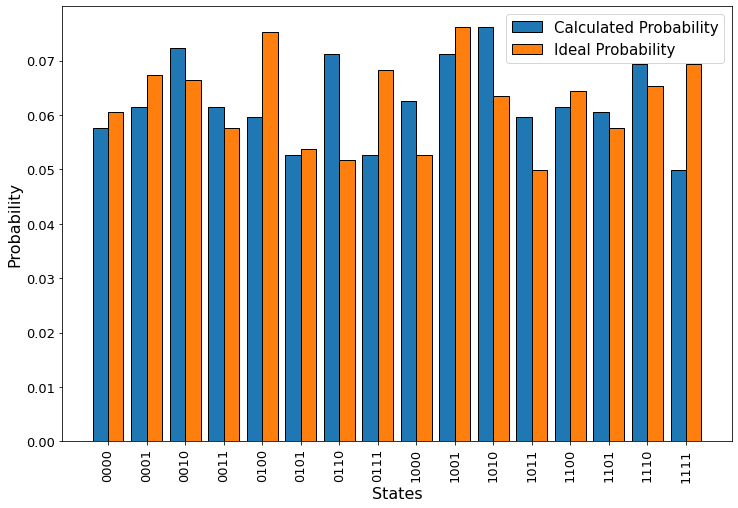

 TVD Distribution
1000
54 64
0.0048828125
1011
51 61
0.009765625
1110
67 71
0.01171875
0110
53 73
0.021484375
0100
77 61
0.029296875
0010
68 74
0.0322265625
1001
78 73
0.03466796875
1010
65 78
0.041015625
1111
71 51
0.05078125
1101
59 62
0.05224609375
0000
62 59
0.0537109375
0111
70 54
0.0615234375
0011
59 63
0.0634765625
0001
69 63
0.06640625
1100
66 63
0.06787109375
0101
55 54
0.068359375
Jensen-Shannon Distance
0.048867390580810965
Hellinger Distance
1.5644710226456064
1.5644710226456064
1.5644710226456064
0.059550105850497886


In [112]:
bit_error(swap_qaoa_circ, len(swap_qaoa_q), 'Swap QAOA')

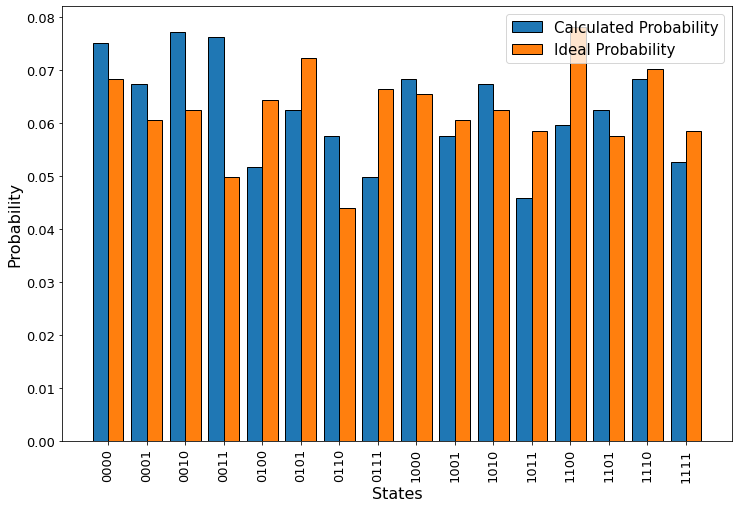

TVD Distribution
1011
60 47
0.00634765625
0010
64 79
0.013671875
1110
72 70
0.0146484375
1001
62 59
0.01611328125
0001
62 69
0.01953125
1101
59 64
0.02197265625
0011
51 78
0.03515625
0000
70 77
0.03857421875
0111
68 51
0.046875
1111
60 54
0.0498046875
1010
64 69
0.05224609375
0101
74 64
0.05712890625
1100
80 61
0.06640625
1000
67 70
0.06787109375
0110
45 59
0.07470703125
0100
66 53
0.0810546875
Jensen-Shannon Distance
0.0629974726639709
Hellinger Distance
2.0174926474440786
2.0174926474440786
2.0174926474440786
0.06902886277887976


In [113]:
t1_t2(len(swap_qaoa_q), swap_qaoa_circ, 'Swap QAOA')

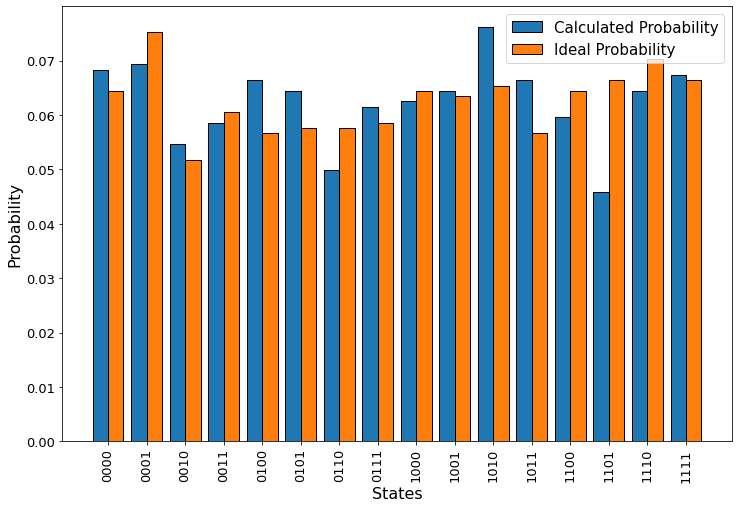

TVD Distribution
1011
58 68
0.0048828125
1000
66 64
0.005859375
0010
53 56
0.00732421875
1110
72 66
0.01025390625
0001
77 71
0.01318359375
1111
68 69
0.013671875
1010
67 78
0.01904296875
1100
66 61
0.021484375
0101
59 66
0.02490234375
1101
68 47
0.03515625
1001
65 66
0.03564453125
0011
62 60
0.03662109375
0000
66 70
0.03857421875
0111
60 63
0.0400390625
0110
59 51
0.0439453125
0100
58 68
0.048828125
Jensen-Shannon Distance
0.05271951763804554
Hellinger Distance
1.687940461477131
1.687940461477131
1.687940461477131
0.04507178411637099


(0.048828125,
 0.05271951763804554,
 1.687940461477131,
 1.687940461477131,
 1.687940461477131)

In [114]:
depolar(len(swap_qaoa_q), swap_qaoa_circ, 'Swap QAOA')

In [115]:
vanilla_qaoa_q = QuantumRegister(3)
vanilla_qaoa_c = ClassicalRegister(3)
vanilla_qaoa_circ = QuantumCircuit(vanilla_qaoa_q, vanilla_qaoa_c)
vanilla_qaoa_circ.h(vanilla_qaoa_q[0:3])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.rz(np.pi/2, 1)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/3, 0)
vanilla_qaoa_circ.rz(np.pi/3, 1)
vanilla_qaoa_circ.rz(np.pi/3, 2)
vanilla_qaoa_circ.barrier()
vanilla_qaoa_circ.measure(vanilla_qaoa_q[0:3], vanilla_qaoa_c[0:3])
display(vanilla_qaoa_circ.draw())

┌───┐                                          ┌─────────┐           »
q583_0: ┤ H ├──■───────────────■────■───────────────■──┤ Rz(π/3) ├───────────»
        ├───┤┌─┴─┐┌─────────┐┌─┴─┐  │               │  └─────────┘           »
q583_1: ┤ H ├┤ X ├┤ Rz(π/2) ├┤ X ├──┼───────────────┼───────■────────────────»
        ├───┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐   ┌─┴─┐   ┌─────────┐»
q583_2: ┤ H ├─────────────────────┤ X ├┤ Rz(π/2) ├┤ X ├───┤ X ├───┤ Rz(π/2) ├»
        └───┘                     └───┘└─────────┘└───┘   └───┘   └─────────┘»
 c15: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«                         ░ ┌─┐      
«q583_0: ─────────────────░─┤M├──────
«             ┌─────────┐ ░ └╥┘┌─┐   
«q583_1: ──■──┤ Rz(π/3) ├─░──╫─┤M├───
«        ┌─┴─┐├─────────┤ ░  ║ └╥┘┌─┐
«q583_2: ┤ X ├┤ Rz(π/3) ├─░──╫──╫─┤M├
«        └───┘└─────────┘ ░  ║  ║ └╥┘
« c15: 3/════════════════════╩══╩══╩═
«                            0  1  2

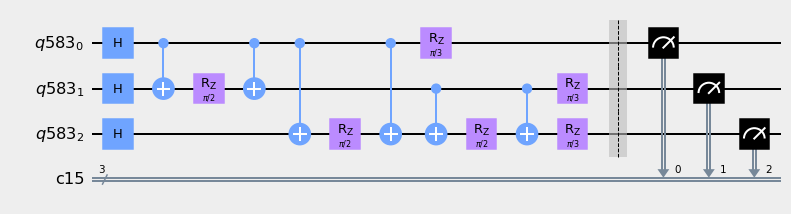

In [116]:
circuit_drawer(vanilla_qaoa_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/vanilla_qaoa_circ.pdf')

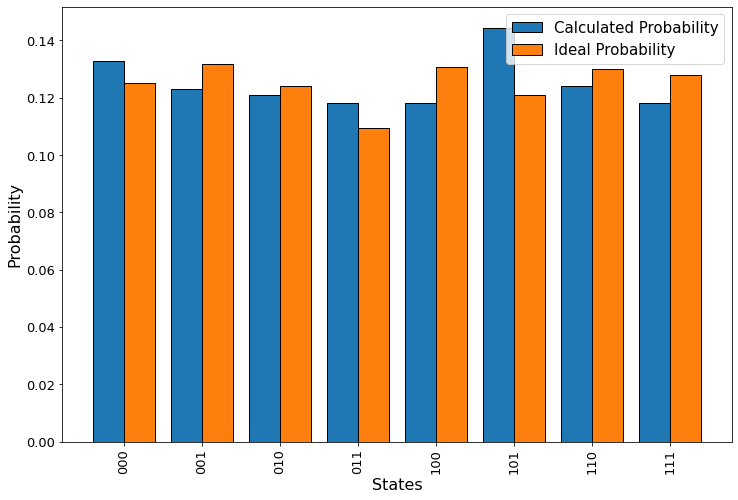

 TVD Distribution
010
127 124
0.00146484375
111
131 121
0.00634765625
000
128 136
0.01025390625
011
112 121
0.0146484375
001
135 126
0.01904296875
101
124 148
0.03076171875
110
133 127
0.03369140625
100
134 121
0.0400390625
Jensen-Shannon Distance
0.039797289883750926
Hellinger Distance
1.2743303183642725
1.2743303183642725
1.2743303183642725
0.032238154394337144


In [117]:
bit_error(vanilla_qaoa_circ, len(vanilla_qaoa_q), 'Vanilla QAOA')

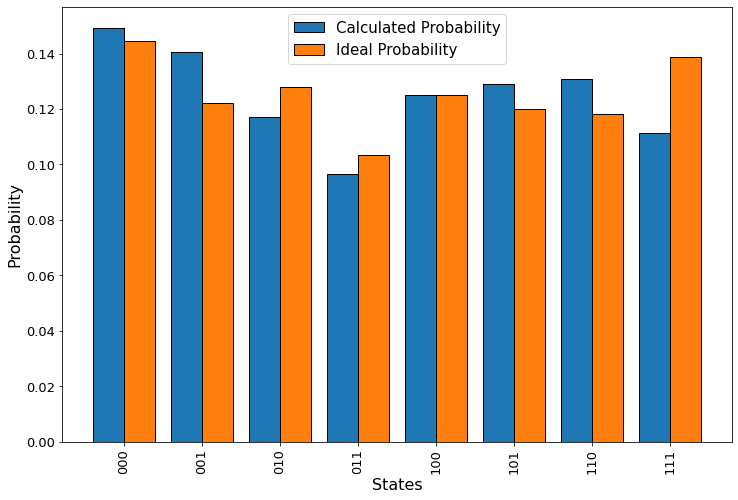

TVD Distribution
010
131 120
0.00537109375
100
128 128
0.00537109375
110
121 134
0.01171875
101
123 132
0.01611328125
001
125 144
0.025390625
000
148 153
0.02783203125
111
142 114
0.04150390625
011
106 99
0.044921875
Jensen-Shannon Distance
0.0740002629465749
Hellinger Distance
2.370720230928416
2.370720230928416
2.370720230928416
0.038908388876203105


In [118]:
t1_t2(len(vanilla_qaoa_q), vanilla_qaoa_circ, 'Vanilla QAOA')

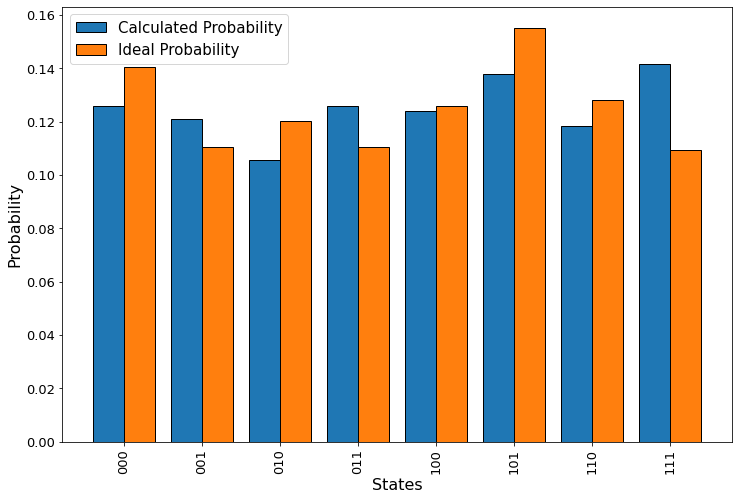

TVD Distribution
101
159 141
0.0087890625
010
123 108
0.01611328125
001
113 124
0.021484375
000
144 129
0.02880859375
111
112 145
0.044921875
011
113 129
0.052734375
110
131 121
0.0576171875
100
129 127
0.05859375
Jensen-Shannon Distance
0.0655669276295497
Hellinger Distance
2.100246391316322
2.100246391316322
2.100246391316322
0.047181895692248635


(0.05859375,
 0.0655669276295497,
 2.100246391316322,
 2.100246391316322,
 2.100246391316322)

In [119]:
depolar(len(vanilla_qaoa_q), vanilla_qaoa_circ, 'Vanilla QAOA')

In [120]:
hamilton_q = QuantumRegister(3)
hamilton_c = ClassicalRegister(3)
hamilton_circ = QuantumCircuit(hamilton_q, hamilton_c)
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.rz(np.pi/2, hamilton_q[0:4])
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.rz(np.pi/3, 1)
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.rz(np.pi/3, 2)
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.barrier()
hamilton_circ.measure(hamilton_q[0:3], hamilton_c[0:3])
display(hamilton_circ.draw())

┌───┐┌─────────┐┌───┐                                           ░ ┌─┐»
q620_0: ┤ H ├┤ Rz(π/2) ├┤ H ├──■───────────────■────────────────────────░─┤M├»
        ├───┤├─────────┤├───┤┌─┴─┐┌─────────┐┌─┴─┐                      ░ └╥┘»
q620_1: ┤ H ├┤ Rz(π/2) ├┤ H ├┤ X ├┤ Rz(π/3) ├┤ X ├──■───────────────■───░──╫─»
        ├───┤├─────────┤├───┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐ ░  ║ »
q620_2: ┤ H ├┤ Rz(π/2) ├┤ H ├─────────────────────┤ X ├┤ Rz(π/3) ├┤ X ├─░──╫─»
        └───┘└─────────┘└───┘                     └───┘└─────────┘└───┘ ░  ║ »
 c16: 3/═══════════════════════════════════════════════════════════════════╩═»
                                                                           0 »
«              
«q620_0: ──────
«        ┌─┐   
«q620_1: ┤M├───
«        └╥┘┌─┐
«q620_2: ─╫─┤M├
«         ║ └╥┘
« c16: 3/═╩══╩═
«         1  2

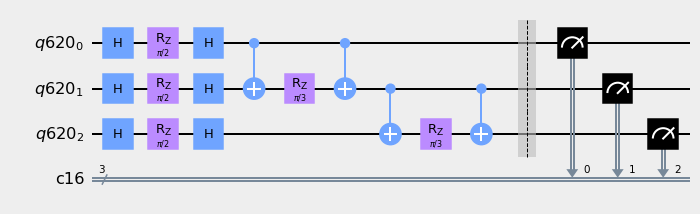

In [121]:
circuit_drawer(hamilton_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/hamilton_circ.pdf')

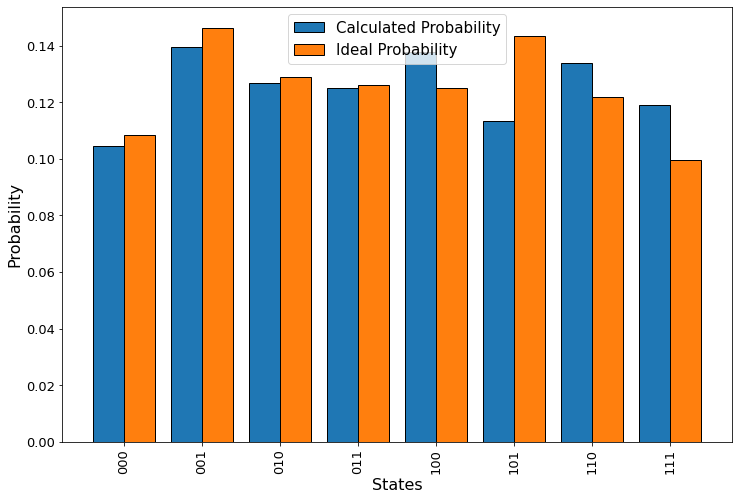

 TVD Distribution
101
147 116
0.01513671875
001
150 143
0.0185546875
010
132 130
0.01953125
111
102 122
0.029296875
011
129 128
0.02978515625
000
111 107
0.03173828125
110
125 137
0.03759765625
100
128 141
0.0439453125
Jensen-Shannon Distance
0.04742102450991005
Hellinger Distance
1.5180551124562278
1.5180551124562278
1.5180551124562278
0.0410268760785379


In [122]:
bit_error(hamilton_circ, len(hamilton_q), 'Hamiltonian')

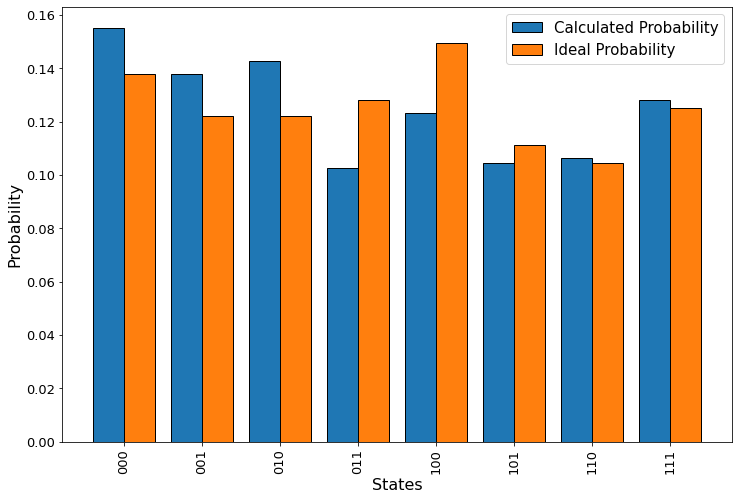

TVD Distribution
001
125 141
0.0078125
101
114 107
0.01123046875
100
153 126
0.0244140625
110
107 109
0.025390625
010
125 146
0.03564453125
000
141 159
0.04443359375
011
131 105
0.05712890625
111
128 131
0.05859375
Jensen-Shannon Distance
0.07615848006205841
Hellinger Distance
2.439041247181853
2.439041247181853
2.439041247181853
0.04801034884279659


In [123]:
t1_t2(len(hamilton_q), hamilton_circ, 'Hamiltonian')

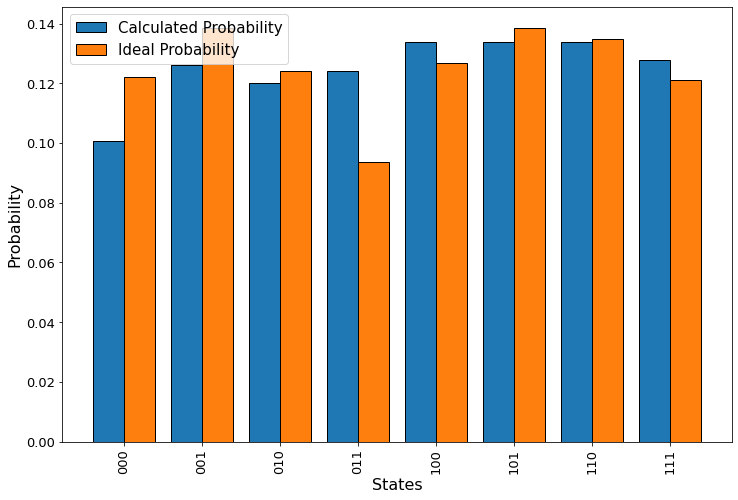

TVD Distribution
110
138 137
0.00048828125
100
130 137
0.00390625
001
142 129
0.01025390625
101
142 137
0.0126953125
011
96 127
0.02783203125
111
124 131
0.03125
000
125 103
0.0419921875
010
127 123
0.0439453125
Jensen-Shannon Distance
0.05119718575724819
Hellinger Distance
1.6399123453427922
1.6399123453427922
1.6399123453427926
0.043118165163494176


(0.0439453125,
 0.05119718575724819,
 1.6399123453427922,
 1.6399123453427922,
 1.6399123453427926)

In [124]:
depolar(len(hamilton_q), hamilton_circ, 'Hamiltonian')

# Table

In [125]:
distance_dataframe

,State Name,Error Introduced,TVD Distribution,Jensen-Shannon Distance,Hellinger Distance
0,GHZ,Bit Error,0.552734,0.671626,0.575589
1,GHZ,Thermal Error,0.055664,0.826572,0.168860
2,GHZ,Depolarizing Error,0.137695,0.768309,0.267204
3,Mermin,Bit Error,0.745117,0.745375,0.703662
4,Mermin,Thermal Error,0.078125,0.828298,0.199642
5,Mermin,Depolarizing Error,0.151367,0.821676,0.280691
6,Phase,Bit Error,0.433594,0.718665,0.498318
7,Phase,Thermal Error,0.059570,0.800651,0.165148
8,Phase,Depolarizing Error,0.094727,0.783709,0.220902
9,Bit,Bit Error,0.778320,0.826520,0.727442
